In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

brent = pd.read_csv("datathon data/crude_oil/BRENT.csv")
makeup = pd.read_csv("datathon data/monthly_gasoline_makeup_percentages.csv")
makeup = makeup[makeup['Type'] == 'Regular']
gas_prices = pd.read_csv("datathon data/gas_prices/regular_formulated_gas_prices.csv")

brent = brent.rename({"Price":"Brent_Price"}, axis=1)
# Ensure dates are in datetime format
makeup['Date'] = pd.to_datetime(makeup['Date'])
gas_prices['Date'] = pd.to_datetime(gas_prices['Date'])
brent['Date'] = pd.to_datetime(brent['Date'])

# Extract Year and Month in both DataFrames
makeup['Year'] = makeup['Date'].dt.year
makeup['Month'] = makeup['Date'].dt.month
gas_prices['Year'] = gas_prices['Date'].dt.year
gas_prices['Month'] = gas_prices['Date'].dt.month
brent['Year'] = brent['Date'].dt.year
brent['Month'] = brent['Date'].dt.month

scaler = StandardScaler()

## Data Processing
- Three datasets are used:
  -  makeup: Monthly composition of gasoline prices (e.g. Refining, Taxes).
  - gas_prices: Weekly gasoline retail prices.
  - brent: Daily crude oil prices.
- Alignment of time frequencies:
  - Monthly makeup data is interpolated to weekly values using linear interpolation.
  - Daily brent prices are aggregated to weekly averages.
  - The result  **gas_brent_linear**  Inis a weekly-aligned dataset with: Weekly gas prices, Weekly estimates of the components (Refining, Taxes, etc.), Weekly Brent crude oil averages.

### Interpolate Monthly Makeup to Weekly
- same values for this month
- linearly interpolate

In [2]:
makeup.describe()

,Date,Retail_Price,Refining,Distribution_and_Marketing,Taxes,Crude_Oil,Year,Month
count,288,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000
mean,2011-12-16 11:00:00,2.609882,14.184028,12.642014,18.575694,54.554167,2011.500000,6.500000
min,2000-01-01 00:00:00,1.086000,-3.700000,-3.900000,9.800000,25.400000,2000.000000,1.000000
25%,2005-12-24 06:00:00,2.046250,10.400000,9.300000,13.575000,46.875000,2005.750000,3.750000
50%,2011-12-16 12:00:00,2.591500,13.900000,11.800000,17.600000,53.900000,2011.500000,6.500000
75%,2017-12-08 18:00:00,3.268500,17.825000,15.025000,21.925000,63.325000,2017.250000,9.250000
max,2023-12-01 00:00:00,4.929000,31.600000,46.400000,38.700000,80.000000,2023.000000,12.000000
std,NaN,0.788535,5.808874,5.355892,6.129380,10.027588,6.934236,3.458061


In [3]:
first_week = gas_prices.groupby(['Year', 'Month'])['Date'].min().reset_index()
gas_prices_same = pd.merge(gas_prices, makeup, on=['Year', 'Month'], how='left').drop(columns=['Date_y', 'Date_String']).rename({"Date_x":"Date"}, axis=1)

# Merge with monthly makeup data on Year and Month
merged = pd.merge(first_week, makeup, on=['Year', 'Month'], how='left')

# Now map these monthly values back to the gas_prices DataFrame
gas_prices_combined = pd.merge(gas_prices, merged[['Date_x', 'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil']], 
                      left_on='Date', right_on='Date_x', how='left')

# Drop the merge helper column
gas_prices_combined.drop(columns='Date_x', inplace=True)

gas_prices_linear = gas_prices_combined

# Interpolate the missing values linearly
for col in ['Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil']:
    gas_prices_linear[col] = gas_prices_linear[col].interpolate(method='linear', limit_direction='both')


### Aggregate Brent to Weekly (average)

In [4]:
brent

,Date,Brent_Price,Commodity,Commodity_Simple,Unit,Year,Month
0,2024-01-22,81.70,Brent Crude Oil,BRENT,Dollars per Barrel,2024,1
1,2024-01-19,80.71,Brent Crude Oil,BRENT,Dollars per Barrel,2024,1
2,2024-01-18,81.04,Brent Crude Oil,BRENT,Dollars per Barrel,2024,1
3,2024-01-17,78.88,Brent Crude Oil,BRENT,Dollars per Barrel,2024,1
4,2024-01-16,80.15,Brent Crude Oil,BRENT,Dollars per Barrel,2024,1
...,...,...,...,...,...,...,...
9564,1987-05-26,18.63,Brent Crude Oil,BRENT,Dollars per Barrel,1987,5
9565,1987-05-25,18.60,Brent Crude Oil,BRENT,Dollars per Barrel,1987,5
9566,1987-05-22,18.55,Brent Crude Oil,BRENT,Dollars per Barrel,1987,5
9567,1987-05-21,18.45,Brent Crude Oil,BRENT,Dollars per Barrel,1987,5


In [5]:
brent_weekly = brent.resample('W-MON', on='Date')['Brent_Price'].mean().reset_index()
gas_brent_linear = pd.merge(gas_prices_linear, brent_weekly, on='Date', how ='inner')
gas_brent_same = pd.merge(gas_prices_same, brent_weekly, on='Date', how ='inner')

In [6]:
gas_brent_linear.to_csv("datathon data/gas_prices/regular_formulated_gas_prices_rf_linear.csv")
gas_brent_same.to_csv("datathon data/gas_prices/regular_formulated_gas_prices_rf_same.csv")

In [7]:
gas_brent_linear.columns

Index(['Date', 'Year', 'Type', 'Type_Clean', 'Unit', 'Geography', 'Price',
       'Month', 'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil',
       'Brent_Price'],
      dtype='object')

### Feature Engineering

Computes log-returns and percentage changes for:
- Retail gasoline prices,
- Each price component (Refining, Taxes, etc.),
- Crude oil prices.
- Generates lagged features (e.g., previous 1 to 4 months' returns) to examine delayed effects.

In [8]:
# Get the pct and logreturn
for col in ['Price', 'Brent_Price', 'Refining', 'Taxes', 'Distribution_and_Marketing', 'Crude_Oil']:
    gas_brent_linear[f'{col}_logreturn'] = np.log(gas_brent_linear[col] / gas_brent_linear[col].shift(1))
    gas_brent_linear[f'{col}_pct'] = gas_brent_linear[col].pct_change()
    gas_brent_same[f'{col}_logreturn'] = np.log(gas_brent_same[col] / gas_brent_same[col].shift(1))
    gas_brent_same[f'{col}_pct'] = gas_brent_same[col].pct_change()
    gas_brent_linear[f'{col}_logreturn_normalized'] = scaler.fit_transform(np.array(gas_brent_linear[f'{col}_logreturn']).reshape(-1, 1))
lag = 1
gas_brent_linear[f'Price_lag_{lag}'] = gas_brent_linear['Price'].shift(lag)

/Users/yangzejia/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/yangzejia/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/yangzejia/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/yangzejia/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Train XGBoost and Random Forest

**Aim**: Use weekly-level data to build a predictive model for gasoline price or its change (log-return or pct change).


**Approach**:
- Use Random Forest or XGBoost for prediction.
- Train model using:
  - Log-returns or pct changes of interpolated components.
  - Weekly crude oil changes.
- Extract feature importances to assess which factors matter most.

In [9]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

['Brent_Price_logreturn_normalized', 'Refining_logreturn_normalized', 'Taxes_logreturn_normalized', 'Distribution_and_Marketing_logreturn_normalized', 'Crude_Oil_logreturn_normalized']
MSE: 0.4668879679314706
Feature Importantce                                            feature  importance
2                       Taxes_logreturn_normalized    0.544282
3  Distribution_and_Marketing_logreturn_normalized    0.169223
0                 Brent_Price_logreturn_normalized    0.152510
4                   Crude_Oil_logreturn_normalized    0.074215
1                    Refining_logreturn_normalized    0.059770
                      feature  importance
2                       Taxes    0.544282
3  Distribution_and_Marketing    0.169223
0                 Brent_Price    0.152510
4                   Crude_Oil    0.074215
1                    Refining    0.059770


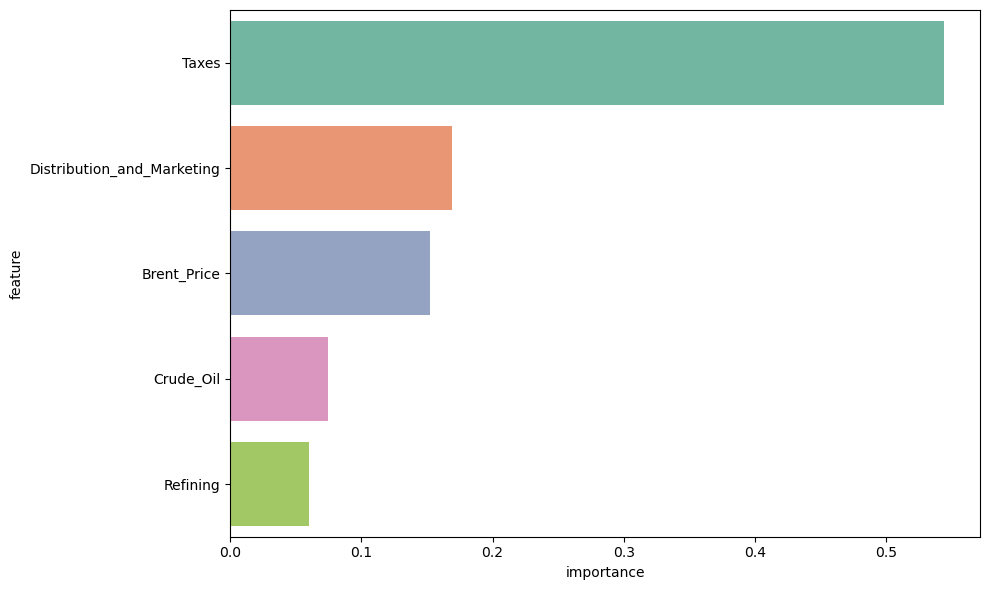

In [11]:
# Drop NA rows due to lag
gas_brent_linear = gas_brent_linear.dropna()

# Features and target, to fit log return 
feature_cols = ['Brent_Price_logreturn',
        'Refining_logreturn',
       'Taxes_logreturn',  'Distribution_and_Marketing_logreturn',
        'Crude_Oil_logreturn',]

feature_cols_normalized = [col + '_normalized' for col in feature_cols]

print(feature_cols_normalized)

X = gas_brent_linear[feature_cols_normalized]
y = gas_brent_linear['Price_logreturn_normalized']  # or 'Price' or 'Price_pct'

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model
model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

importance = model.feature_importances_
feat_importance = pd.DataFrame({'feature': X.columns, 'importance': importance})
feat_importance = feat_importance.sort_values('importance', ascending=False)

print("Feature Importantce", feat_importance)

plt.figure(figsize=(10, 6))

feat_importance['feature'] = feat_importance['feature'].apply(lambda x : x[:-21])
print(feat_importance)
sns.barplot(x='importance', y='feature', data=feat_importance, palette='Set2')

# plt.title("Feature Importance, normalized")
plt.tight_layout()
plt.show()


['Price_lag_1', 'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil', 'Brent_Price', 'Brent_Price_logreturn_normalized', 'Refining_logreturn_normalized', 'Taxes_logreturn_normalized', 'Distribution_and_Marketing_logreturn_normalized', 'Crude_Oil_logreturn_normalized']
MSE: 0.04018138611553872


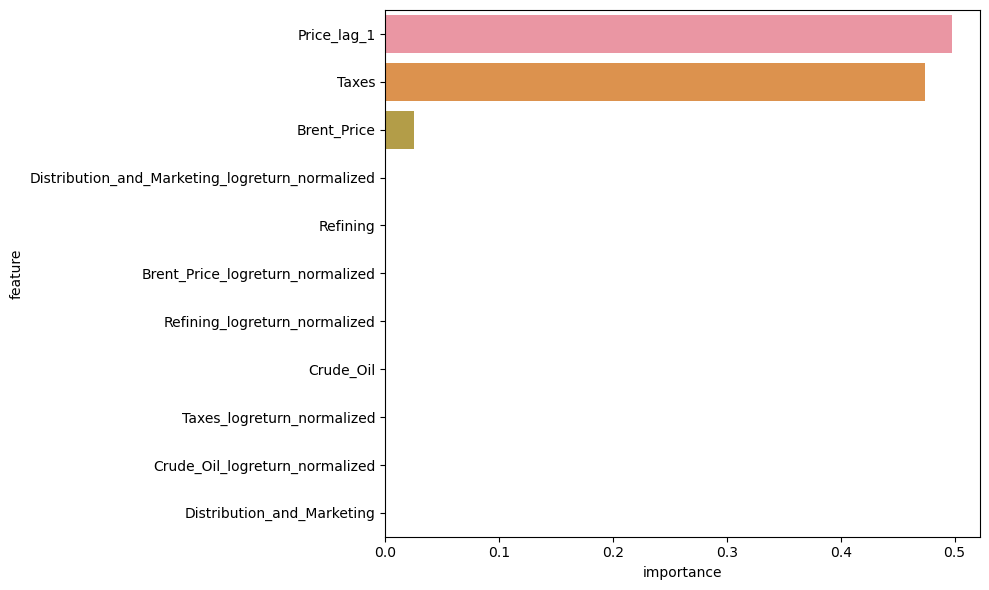

Feature Importantce                                             feature  importance
0                                       Price_lag_1    0.497407
3                                             Taxes    0.474233
5                                       Brent_Price    0.025346
9   Distribution_and_Marketing_logreturn_normalized    0.000624
1                                          Refining    0.000520
6                  Brent_Price_logreturn_normalized    0.000432
7                     Refining_logreturn_normalized    0.000372
4                                         Crude_Oil    0.000346
8                        Taxes_logreturn_normalized    0.000330
10                   Crude_Oil_logreturn_normalized    0.000233
2                        Distribution_and_Marketing    0.000156


In [ ]:
# Features and target, to fit log return 
feature_cols = [
    f'Price_lag_{lag}',
        'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil',
       'Brent_Price',
       ]
print(feature_cols + feature_cols_normalized)
X = gas_brent_linear[feature_cols + feature_cols_normalized]
y = gas_brent_linear['Price']  # or 'Price' or 'Price_pct'

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model
model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

importance = model.feature_importances_
feat_importance = pd.DataFrame({'feature': X.columns, 'importance': importance})
feat_importance = feat_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_importance)
plt.tight_layout()
plt.yticks(rotation = 0)
plt.show()
print("Feature Importantce", feat_importance)

['Price_lag_1', 'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil', 'Brent_Price', 'Brent_Price_logreturn', 'Refining_logreturn', 'Taxes_logreturn', 'Distribution_and_Marketing_logreturn', 'Crude_Oil_logreturn']
MSE: 0.0002495436916790246
Feature Importantce                                             feature  importance
8                                   Taxes_logreturn    0.387661
6                             Brent_Price_logreturn    0.200507
9              Distribution_and_Marketing_logreturn    0.126760
7                                Refining_logreturn    0.051389
10                              Crude_Oil_logreturn    0.041090
2                        Distribution_and_Marketing    0.040006
1                                          Refining    0.038232
4                                         Crude_Oil    0.032703
5                                       Brent_Price    0.031938
3                                             Taxes    0.027106
0                        

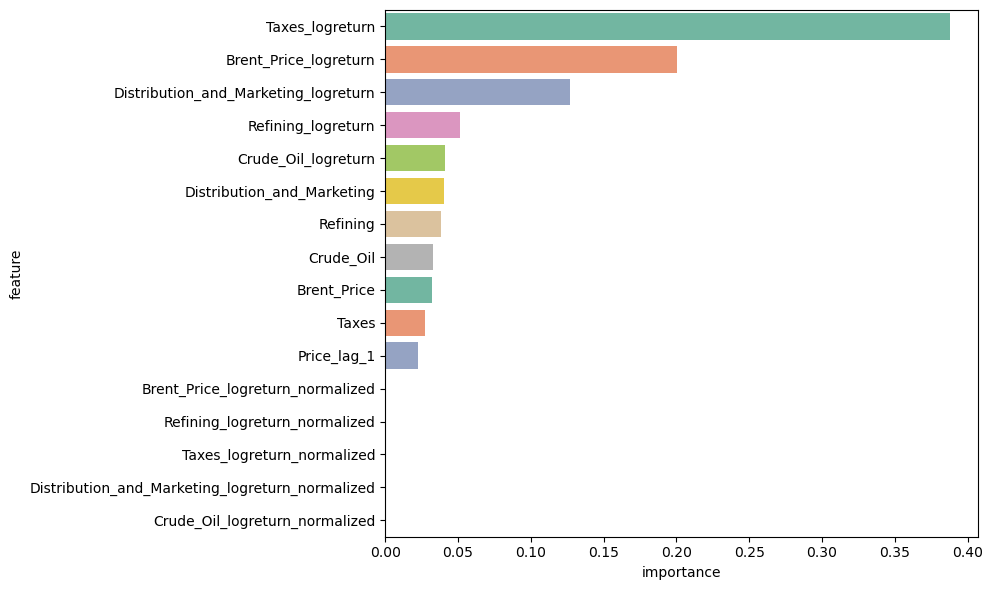

In [ ]:
feature_cols = [f'Price_lag_{lag}',
        'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil',
       'Brent_Price', 'Brent_Price_logreturn',
        'Refining_logreturn',
       'Taxes_logreturn',  'Distribution_and_Marketing_logreturn',
        'Crude_Oil_logreturn',
       ]
print(feature_cols)
X = gas_brent_linear[feature_cols + feature_cols_normalized]
y = gas_brent_linear['Price_logreturn']  # or 'Price' or 'Price_pct'

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model
model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

importance = model.feature_importances_
feat_importance = pd.DataFrame({'feature': X.columns, 'importance': importance})
feat_importance = feat_importance.sort_values('importance', ascending=False)

print("Feature Importantce", feat_importance)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_importance, palette='Set2')
plt.tight_layout()
plt.yticks(rotation = 0)
plt.show()

### Clustering for different areas in US

In [12]:
gas_prices_us = pd.read_csv("datathon data/weekly_gasoline_prices.csv")
gas_prices_us = gas_prices_us[gas_prices_us['Type_Clean'] == 'Regular All Formulations Retail Gasoline Prices']
gas_prices_us['Date'] = pd.to_datetime(gas_prices_us['Date'])
gas_prices_us['Year'] = gas_prices_us['Date'].dt.year
gas_prices_us['Month'] = gas_prices_us['Date'].dt.month

In [13]:
select_cols = gas_brent_linear[['Date', 'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil',
       'Brent_Price',  'Brent_Price_logreturn', 'Refining_logreturn', 
       'Taxes_logreturn','Distribution_and_Marketing_logreturn', 'Crude_Oil_logreturn',
       'Brent_Price_logreturn_normalized', 'Refining_logreturn_normalized',
       'Taxes_logreturn_normalized',
       'Distribution_and_Marketing_logreturn_normalized',
       'Crude_Oil_logreturn_normalized']]

gas_prices_us_linear = pd.merge(gas_prices_us, select_cols, on='Date', how ='inner')
gas_prices_us_linear = gas_prices_us_linear[gas_prices_us_linear['Date'] <= makeup['Date'].max()]

In [16]:
import pandas as pd
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

target_col = 'Price_logreturn_normalized'
feature_cols = [col for col in gas_prices_us_linear.columns if col.endswith('_logreturn_normalized') and col != target_col]

print(feature_cols)
importance_dict = {}

gas_prices_us_linear = gas_prices_us_linear[gas_prices_us_linear['Date'] <= makeup['Date'].max()]

# Step 1: Train XGBoost model for each geography
for geo in gas_prices_us_linear['Geography'].unique():
    df_geo = gas_prices_us_linear[gas_prices_us_linear['Geography'] == geo]
    df_geo[f'Price_logreturn'] = np.log(df_geo['Price'] / df_geo['Price'].shift(1))
    df_geo[f'Price_logreturn_normalized'] = scaler.fit_transform(np.array(df_geo[f'Price_logreturn']).reshape(-1, 1))
    df_geo.dropna(subset=[target_col] + feature_cols, inplace=True)
    if len(df_geo) < 10:  # Skip if not enough data points
        continue

    X = df_geo[feature_cols]
    y = df_geo[target_col]
    
    print(X.columns)
    # print(y.columns)

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, random_state=0)
    model.fit(X, y)
    
    # Get feature importances
    importance = model.feature_importances_
    importance_dict[geo] = importance

# Step 2: Convert importances into a DataFrame
importance_df = pd.DataFrame.from_dict(
    importance_dict, 
    orient='index', 
    columns=feature_cols
).fillna(0)


['Brent_Price_logreturn_normalized', 'Refining_logreturn_normalized', 'Taxes_logreturn_normalized', 'Distribution_and_Marketing_logreturn_normalized', 'Crude_Oil_logreturn_normalized']
Index(['Brent_Price_logreturn_normalized', 'Refining_logreturn_normalized',
       'Taxes_logreturn_normalized',
       'Distribution_and_Marketing_logreturn_normalized',
       'Crude_Oil_logreturn_normalized'],
      dtype='object')
Index(['Brent_Price_logreturn_normalized', 'Refining_logreturn_normalized',
       'Taxes_logreturn_normalized',
       'Distribution_and_Marketing_logreturn_normalized',
       'Crude_Oil_logreturn_normalized'],
      dtype='object')
Index(['Brent_Price_logreturn_normalized', 'Refining_logreturn_normalized',
       'Taxes_logreturn_normalized',
       'Distribution_and_Marketing_logreturn_normalized',
       'Crude_Oil_logreturn_normalized'],
      dtype='object')
Index(['Brent_Price_logreturn_normalized', 'Refining_logreturn_normalized',
       'Taxes_logreturn_normalized

/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_2166/1842491804.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo[f'Price_logreturn'] = np.log(df_geo['Price'] / df_geo['Price'].shift(1))
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_2166/1842491804.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo[f'Price_logreturn_normalized'] = scaler.fit_transform(np.array(df_geo[f'Price_logreturn']).reshape(-1, 1))
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_216

Index(['Brent_Price_logreturn_normalized', 'Refining_logreturn_normalized',
       'Taxes_logreturn_normalized',
       'Distribution_and_Marketing_logreturn_normalized',
       'Crude_Oil_logreturn_normalized'],
      dtype='object')
Index(['Brent_Price_logreturn_normalized', 'Refining_logreturn_normalized',
       'Taxes_logreturn_normalized',
       'Distribution_and_Marketing_logreturn_normalized',
       'Crude_Oil_logreturn_normalized'],
      dtype='object')
Index(['Brent_Price_logreturn_normalized', 'Refining_logreturn_normalized',
       'Taxes_logreturn_normalized',
       'Distribution_and_Marketing_logreturn_normalized',
       'Crude_Oil_logreturn_normalized'],
      dtype='object')
Index(['Brent_Price_logreturn_normalized', 'Refining_logreturn_normalized',
       'Taxes_logreturn_normalized',
       'Distribution_and_Marketing_logreturn_normalized',
       'Crude_Oil_logreturn_normalized'],
      dtype='object')
Index(['Brent_Price_logreturn_normalized', 'Refining_logretu

/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_2166/1842491804.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo[f'Price_logreturn'] = np.log(df_geo['Price'] / df_geo['Price'].shift(1))
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_2166/1842491804.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo[f'Price_logreturn_normalized'] = scaler.fit_transform(np.array(df_geo[f'Price_logreturn']).reshape(-1, 1))
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_216

Index(['Brent_Price_logreturn_normalized', 'Refining_logreturn_normalized',
       'Taxes_logreturn_normalized',
       'Distribution_and_Marketing_logreturn_normalized',
       'Crude_Oil_logreturn_normalized'],
      dtype='object')
Index(['Brent_Price_logreturn_normalized', 'Refining_logreturn_normalized',
       'Taxes_logreturn_normalized',
       'Distribution_and_Marketing_logreturn_normalized',
       'Crude_Oil_logreturn_normalized'],
      dtype='object')
Index(['Brent_Price_logreturn_normalized', 'Refining_logreturn_normalized',
       'Taxes_logreturn_normalized',
       'Distribution_and_Marketing_logreturn_normalized',
       'Crude_Oil_logreturn_normalized'],
      dtype='object')
Index(['Brent_Price_logreturn_normalized', 'Refining_logreturn_normalized',
       'Taxes_logreturn_normalized',
       'Distribution_and_Marketing_logreturn_normalized',
       'Crude_Oil_logreturn_normalized'],
      dtype='object')
Index(['Brent_Price_logreturn_normalized', 'Refining_logretu

/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_2166/1842491804.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo[f'Price_logreturn'] = np.log(df_geo['Price'] / df_geo['Price'].shift(1))
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_2166/1842491804.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo[f'Price_logreturn_normalized'] = scaler.fit_transform(np.array(df_geo[f'Price_logreturn']).reshape(-1, 1))
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_216

Index(['Brent_Price_logreturn_normalized', 'Refining_logreturn_normalized',
       'Taxes_logreturn_normalized',
       'Distribution_and_Marketing_logreturn_normalized',
       'Crude_Oil_logreturn_normalized'],
      dtype='object')
Index(['Brent_Price_logreturn_normalized', 'Refining_logreturn_normalized',
       'Taxes_logreturn_normalized',
       'Distribution_and_Marketing_logreturn_normalized',
       'Crude_Oil_logreturn_normalized'],
      dtype='object')
Index(['Brent_Price_logreturn_normalized', 'Refining_logreturn_normalized',
       'Taxes_logreturn_normalized',
       'Distribution_and_Marketing_logreturn_normalized',
       'Crude_Oil_logreturn_normalized'],
      dtype='object')
Index(['Brent_Price_logreturn_normalized', 'Refining_logreturn_normalized',
       'Taxes_logreturn_normalized',
       'Distribution_and_Marketing_logreturn_normalized',
       'Crude_Oil_logreturn_normalized'],
      dtype='object')
Index(['Brent_Price_logreturn_normalized', 'Refining_logretu

/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_2166/1842491804.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo[f'Price_logreturn'] = np.log(df_geo['Price'] / df_geo['Price'].shift(1))
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_2166/1842491804.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo[f'Price_logreturn_normalized'] = scaler.fit_transform(np.array(df_geo[f'Price_logreturn']).reshape(-1, 1))
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_216

Index(['Brent_Price_logreturn_normalized', 'Refining_logreturn_normalized',
       'Taxes_logreturn_normalized',
       'Distribution_and_Marketing_logreturn_normalized',
       'Crude_Oil_logreturn_normalized'],
      dtype='object')
Index(['Brent_Price_logreturn_normalized', 'Refining_logreturn_normalized',
       'Taxes_logreturn_normalized',
       'Distribution_and_Marketing_logreturn_normalized',
       'Crude_Oil_logreturn_normalized'],
      dtype='object')
Index(['Brent_Price_logreturn_normalized', 'Refining_logreturn_normalized',
       'Taxes_logreturn_normalized',
       'Distribution_and_Marketing_logreturn_normalized',
       'Crude_Oil_logreturn_normalized'],
      dtype='object')
Index(['Brent_Price_logreturn_normalized', 'Refining_logreturn_normalized',
       'Taxes_logreturn_normalized',
       'Distribution_and_Marketing_logreturn_normalized',
       'Crude_Oil_logreturn_normalized'],
      dtype='object')
Index(['Brent_Price_logreturn_normalized', 'Refining_logretu

/Users/yangzejia/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_2166/1842491804.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo[f'Price_logreturn_normalized'] = scaler.fit_transform(np.array(df_geo[f'Price_logreturn']).reshape(-1, 1))
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_2166/1842491804.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(np.array(importance_df))

importance_df['Cluster'] = clusters


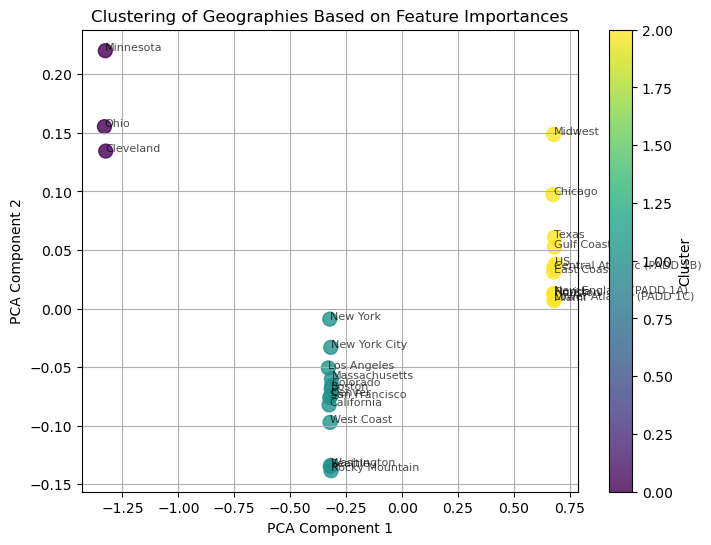

In [ ]:
## Plot against PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(np.array(importance_df))  # <- from your scaled feature matrix

plt.figure(figsize=(8, 6))
scatter = plt.scatter(components[:, 0], components[:, 1], label=importance_df.index, c = clusters, cmap='viridis', s=100, alpha=0.8)

for i, geo in enumerate(importance_df.index):
    plt.text(components[i, 0], components[i, 1], geo, fontsize=8, alpha=0.7)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clustering of Geographies Based on Feature Importances')
plt.grid(True)
plt.colorbar(scatter, label='Cluster')
plt.show()

In [ ]:
len(geo_name_map)

30

In [ ]:
geo_name_map = {
    'US': 'United States',
    'East Coast': 'East Coast',
    'New England (PADD 1A)': 'New England',
    'Central Atlantic (PADD 1B)': 'Central Atlantic',
    'Lower Atlantic (PADD 1C)': 'Lower Atlantic',
    'Midwest': 'Midwest',
    'Gulf Coast': 'Gulf Coast',
    'Rocky Mountain': 'Rocky Mountain',
    'West Coast': 'West Coast',
    'California': 'California',
    'Colorado': 'Colorado',
    'Florida': 'Florida',
    'Massachusetts': 'Massachusetts',
    'Minnesota': 'Minnesota',
    'New York': 'New York (State)',
    'Ohio': 'Ohio',
    'Texas': 'Texas',
    'Washington': 'Washington (State)',
    'Boston': 'Boston',
    'Chicago': 'Chicago',
    'Cleveland': 'Cleveland',
    'Denver': 'Denver',
    'Houston': 'Houston',
    'Los Angeles': 'Los Angeles',
    'Miami': 'Miami',
    'New York City': 'New York City',
    'New York Harbor': 'NY Harbor',
    'San Francisco': 'San Francisco',
    'Seattle': 'Seattle',
    'West Coast (PADD 5) Except California': 'West Coast (ex. CA)'
}
geo_coords = {
    'US': {'lat': 39.8283, 'lon': -98.5795},
    'East Coast': {'lat': 36.7783, 'lon': -77.0369},
    'New England (PADD 1A)': {'lat': 43.9654, 'lon': -71.6835},
    'Central Atlantic (PADD 1B)': {'lat': 39.0, 'lon': -76.5},
    'Lower Atlantic (PADD 1C)': {'lat': 33.0, 'lon': -80.0},
    'Midwest': {'lat': 41.8500, 'lon': -87.6500},
    'Gulf Coast': {'lat': 29.7604, 'lon': -95.3698},  # Houston area
    'Rocky Mountain': {'lat': 39.5501, 'lon': -105.7821},
    'West Coast': {'lat': 37.7749, 'lon': -122.4194},
    'California': {'lat': 36.7783, 'lon': -119.4179},
    'Colorado': {'lat': 39.5501, 'lon': -105.7821},
    'Florida': {'lat': 27.9944, 'lon': -81.7603},
    'Massachusetts': {'lat': 42.4072, 'lon': -71.3824},
    'Minnesota': {'lat': 46.7296, 'lon': -94.6859},
    'New York': {'lat': 43.0000, 'lon': -75.0000},
    'Ohio': {'lat': 40.4173, 'lon': -82.9071},
    'Texas': {'lat': 31.9686, 'lon': -99.9018},
    'Washington': {'lat': 47.7511, 'lon': -120.7401},
    'Boston': {'lat': 42.3601, 'lon': -71.0589},
    'Chicago': {'lat': 41.8781, 'lon': -87.6298},
    'Cleveland': {'lat': 41.4993, 'lon': -81.6944},
    'Denver': {'lat': 39.7392, 'lon': -104.9903},
    'Houston': {'lat': 29.7604, 'lon': -95.3698},
    'Los Angeles': {'lat': 34.0522, 'lon': -118.2437},
    'Miami': {'lat': 25.7617, 'lon': -80.1918},
    'New York City': {'lat': 40.7128, 'lon': -74.0060},
    'New York Harbor': {'lat': 40.6687, 'lon': -74.0451},
    'San Francisco': {'lat': 37.7749, 'lon': -122.4194},
    'Seattle': {'lat': 47.6062, 'lon': -122.3321},
    'West Coast (PADD 5) Except California': {'lat': 45.0, 'lon': -120.0},
}

In [ ]:
import plotly.express as px

## Plot against geography
df_map = importance_df.reset_index().rename(columns={'index': 'State'})
df_map['lat'] = df_map['State'].map(lambda x: geo_coords.get(x, {}).get('lat'))
df_map['lon'] = df_map['State'].map(lambda x: geo_coords.get(x, {}).get('lon'))

fig = px.scatter_mapbox(
    df_map,
    lat='lat',
    lon='lon',
    color='Cluster',
    size_max=20,
    hover_name='State',
    zoom=3,
    mapbox_style='carto-positron',
    #title="Gasoline Prices Feature Importance by Geography"
)

fig.update_layout(
    width=900,
    height=600,
    font=dict(family="Arial", size=14, color="black"),
    title_font=dict(family="Arial Black", size=20, color="black")
)

fig.update_traces(marker=dict(size=15))
fig.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


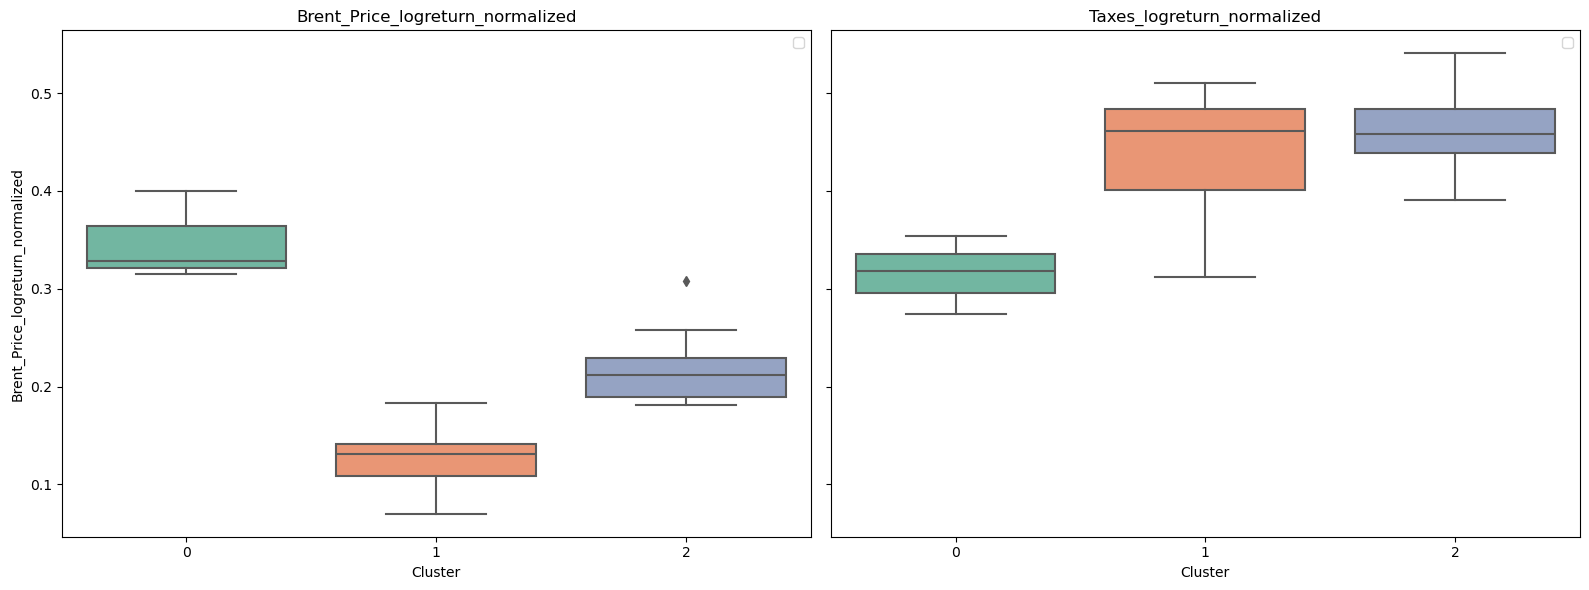

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['Brent_Price_logreturn_normalized', 'Taxes_logreturn_normalized']  # Replace 'Feature2' with your actual feature name
titles = [
    'Brent_Price_logreturn_normalized',
    'Taxes_logreturn_normalized'
]

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for ax, feature, title in zip(axes, features, titles):
    # Boxplot
    sns.boxplot(
        data=importance_df,
        x='Cluster',
        y=feature,
        palette='Set2',
        ax=ax
    )
    
    # Calculate mean and std
    summary_stats = importance_df.groupby('Cluster')[feature].agg(['mean', 'std']).reset_index()

    ax.set_title(title)
    ax.set_xlabel('Cluster')
    if ax == axes[0]:
        ax.set_ylabel(feature)
    else:
        ax.set_ylabel('')
    ax.legend()

plt.tight_layout()
plt.show()




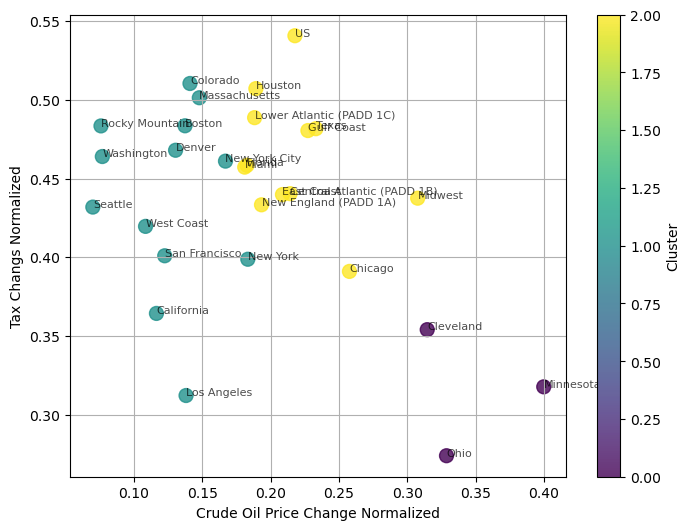

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(importance_df[features[0]], importance_df[features[1]], label=importance_df.index, c = importance_df['Cluster'], cmap='viridis', s=100, alpha=0.8)

for i, geo in enumerate(importance_df.index):
    plt.text(importance_df.at[geo, features[0]], importance_df.at[geo, features[1]], geo, fontsize=8, alpha=0.7)

plt.xlabel('Crude Oil Price Change Normalized')
plt.ylabel('Tax Changs Normalized')
#plt.title('Clustering of Geographies Based on Two Significant Features')
plt.grid(True)
plt.colorbar(scatter, label='Cluster')
plt.show()

### correlation test

<Axes: >

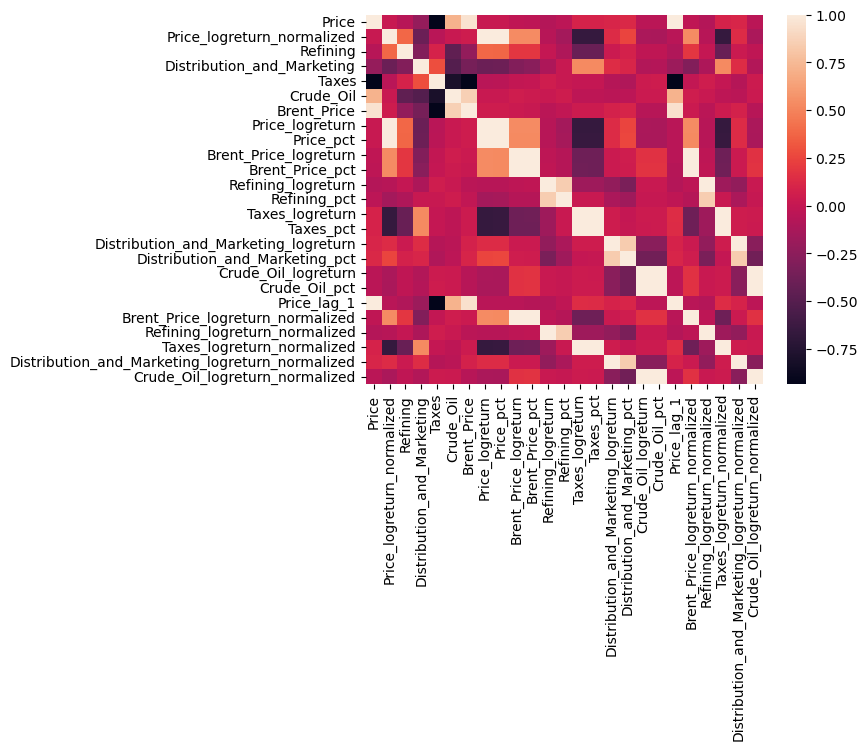

In [ ]:
m = gas_brent_linear[['Price', 'Price_logreturn_normalized',
       'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil',
       'Brent_Price', 'Price_logreturn', 'Price_pct', 'Brent_Price_logreturn',
       'Brent_Price_pct', 'Refining_logreturn', 'Refining_pct',
       'Taxes_logreturn', 'Taxes_pct', 'Distribution_and_Marketing_logreturn',
       'Distribution_and_Marketing_pct', 'Crude_Oil_logreturn',
       'Crude_Oil_pct', 'Price_lag_1'] + feature_cols_normalized].corr()

sns.heatmap(m)

In [ ]:
log_returns = ['Refining_logreturn', 'Distribution_and_Marketing_logreturn', 'Taxes_logreturn', 'Crude_Oil_logreturn', 'Brent_Price_logreturn']
print(m.loc[target_cols,  log_returns])
sns.heatmap(m.loc[target_cols, log_returns], annot=True, cmap='coolwarm')
plt.title("Heatmap: Target vs Component Log Returns")

NameError: name 'target_cols' is not defined